In [1]:
import numpy as np
import xarray as xr
import json
import os
import socket
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import xmitgcm as xm

from utils_mitgcm import open_mitgcm_ds_from_config

import eddytools as et

In [2]:
model = 'geneva_200m'

In [3]:
str_start_time = "2023-07-01T12:00:00.000000000"
str_end_time = "2023-07-01T22:00:00.000000000"

outputpath = "./99-Outputs/nencioli/"

# Open MITgcm results

In [6]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('../config.json', model)

# Preprocess MITgcm inputs

In [7]:
grid_resolution_in_meter = ds_to_plot['XC'].values[1] - ds_to_plot['XC'].values[0]

In [8]:
data_aligned = et.detection_nencioli.preprocess_inputs(str_start_time, str_end_time, ds_to_plot, depth_index=0)

# Plotting eddies

In [9]:
def plot_map_eddies(snapshot_vel, snapshot_eddies, title, stream_density = 6):
    x_plot, y_plot = np.meshgrid(snapshot_vel['lon'], snapshot_vel['lat'])
    u_plot = snapshot_vel['UVEL'].values
    v_plot = snapshot_vel['VVEL'].values
    
    plt.close('all')
    fig = plt.figure(figsize=(12, 7))

    # Plot background scalar field (e.g., UVEL)
    snapshot_vel["UVEL"].plot()

    # Plot streamlines
    plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
                   density=stream_density, color='black', linewidth=0.5, 
                   arrowsize=0.7, arrowstyle='->')

    # Overlay eddies
    for i in range(len(snapshot_eddies)):
        eddy_i = snapshot_eddies[i]['eddy_i']
        eddy_j = snapshot_eddies[i]['eddy_j']
        lon_eddy = snapshot_vel['lon'].values[eddy_i]
        lat_eddy = snapshot_vel['lat'].values[eddy_j]

        try:
            triang = tri.Triangulation(lon_eddy, lat_eddy)
            plt.tripcolor(triang, facecolors=np.full(len(triang.triangles), 1.0), 
                          cmap=plt.cm.Greens, vmin=0, vmax=4, alpha=0.5)
        except Exception as e:
            plt.scatter(lon_eddy, lat_eddy, c='green')
        # Eddy center
        plt.scatter(snapshot_eddies[i]['lon'], snapshot_eddies[i]['lat'], c='black')

    plt.title(title)
    
    return fig

# Detecting eddies at a specific timestep

In [10]:
t_index=2
# Specify parameters for eddy detection
det_param = {
    "model": "MITgcm",
    "grid": "cartesian",
    "hemi": "north",
    "start_time": str_start_time,  # time range start
    "end_time": str_end_time,  # time range end
    "calendar": "standard",  # calendar, must be either 360_day or standard
    "lon1": data_aligned.lon.values.min(),  # minimum longitude of detection region
    "lon2": data_aligned.lon.values.max(),  # maximum longitude
    "lat1": data_aligned.lat.values.min(),  # minimum latitude
    "lat2": data_aligned.lat.values.max(),  # maximum latitude
    "res": grid_resolution_in_meter / 1000,  # resolution of the fields in km
    "min_dep": 1,  # minimum ocean depth where to look for eddies in m
    "no_long": False,  # If True, elongated shapes will not be considered
    "no_two": False,  # If True, eddies with two minima in the OW
    # parameter and a OW > OW_thr in between  will not
    # be considered
    "a": 3, # u/v increase "a" points away from reversal
    "b": 3, # find the velocity minimum within the searching area defined by
            # "b" around the points that satisfy the first two constraints
    "rad": 10, # define the space window in which the algorithm looks for the eddy limits
}

test_eddies = et.detection_nencioli.detect_UV_core(data_aligned, 
                                                   det_param.copy(), 
                                                   data_aligned["UVEL"].compute(), 
                                                   data_aligned["VVEL"].compute(), 
                                                   data_aligned["SPEED"].compute(), 
                                                   t_index, 
                                                   data_aligned['dxC'].values, 
                                                   data_aligned['dyC'].values)

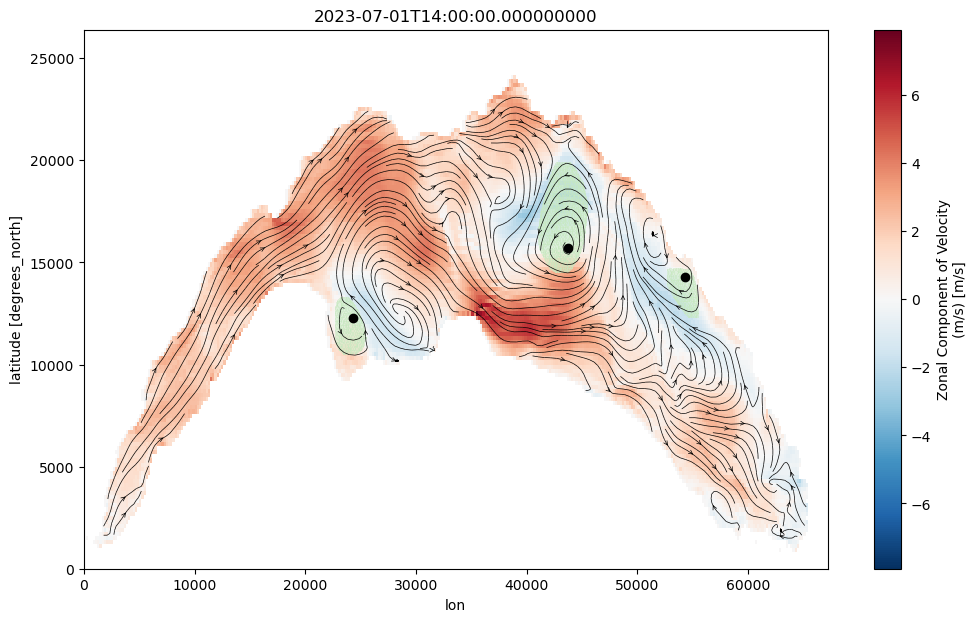

In [11]:
fig = plot_map_eddies(data_aligned.isel(time=t_index), 
                      test_eddies, 
                      str(data_aligned['time'].isel(time=t_index).values),
                      4)

# TESTS

In [155]:
t = t_index
eddi_index = 1
rad = 10
a = 3

In [156]:
i2 = np.where(data_aligned.lon.values == test_eddies[eddi_index]['lon'])[0]
i1 = np.where(data_aligned.lat.values == test_eddies[eddi_index]['lat'])[0]

In [157]:
u = data_aligned.UVEL.isel(time=t).values
v = data_aligned.VVEL.isel(time=t).values
speed = data_aligned.SPEED.isel(time=t).values
e1f = data_aligned['dxC'].values
e2f = data_aligned['dyC'].values

In [158]:
lon, lat = np.meshgrid(data_aligned.lon.sel(lon=slice(data_aligned.lon.values.min(),
                                              data_aligned.lon.values.max())).values,
                       data_aligned.lat.sel(lat=slice(data_aligned.lat.values.min(),
                                              data_aligned.lat.values.max())).values)

In [159]:
bounds = np.shape(speed)

In [160]:
u_large = u[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
            int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
v_large = v[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
            int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
speed_large = speed[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
                    int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
lon_large = lon[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
                int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
lat_large = lat[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
                int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
e1f_large = e1f[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
                int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
e2f_large = e2f[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
                int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]

In [161]:
u_psi = u_large
v_psi = v_large
dx = e1f_large
dy = e2f_large
vel = speed_large

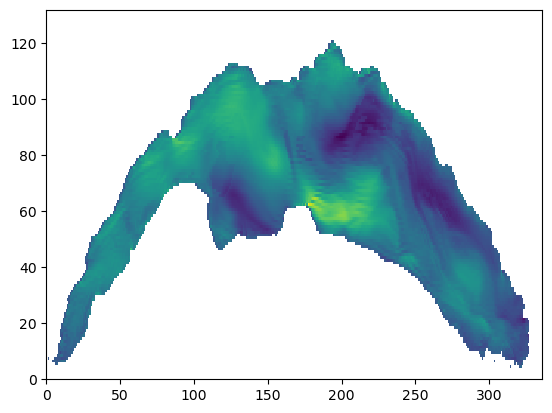

In [162]:
plt.pcolormesh(u)

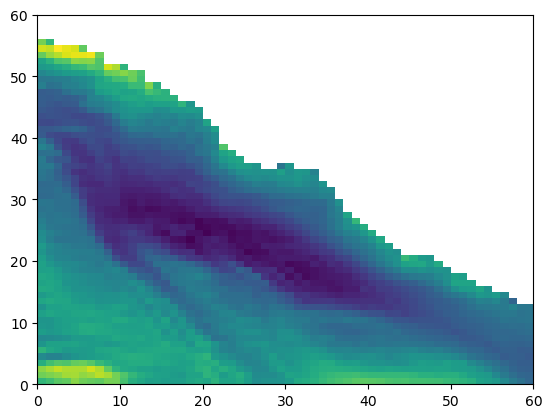

In [163]:
plt.pcolormesh(u_psi)

In [196]:
lx = np.shape(u_psi)[0]
ly = np.shape(u_psi)[1]
# itegrate first row of v along longitude (first term of eq.A2)
cx = np.nancumsum(v_psi[0, :]) * dx[0, :]
# integrate first column of u along latitude (second term of eq.A3)
cy = np.nancumsum(u_psi[:, 0]) * dy[:, 0]
# compute streamfunction
# PSI from integrating v firts and then u
psi_xy = (-cx[None, :] + np.nancumsum(u_psi, axis=0) * dy)
# PSI from integrating u first and then v
psi_yx = (-np.nancumsum(v_psi, axis=1) * dx + cy[:, None])
# final PSI as average between the two
psi = (psi_xy + psi_yx) / 2

psi = np.where(np.isnan(u_psi), np.nan, psi)

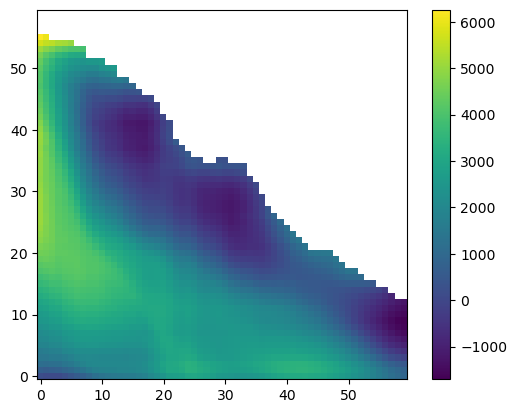

In [197]:
plt.imshow(psi)
plt.gca().invert_yaxis()
plt.colorbar()

In [184]:
from contourpy import contour_generator

In [191]:
cg = contour_generator(range(lx), range(ly), psi)

In [192]:
C = [cg.lines(np.linspace(np.nanmin(psi), np.nanmax(psi), 100)[i]) for i in np.arange(100)]

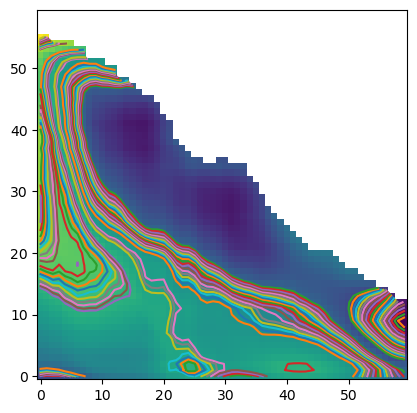

In [193]:
plt.imshow(psi)
plt.gca().invert_yaxis()
for i in range(len(C)-1):
    plt.plot(C[i][0][:,0],C[i][0][:,1])

In [194]:
ec_lon = lon[i1,i2]
ec_lat = lat[i1,i2]

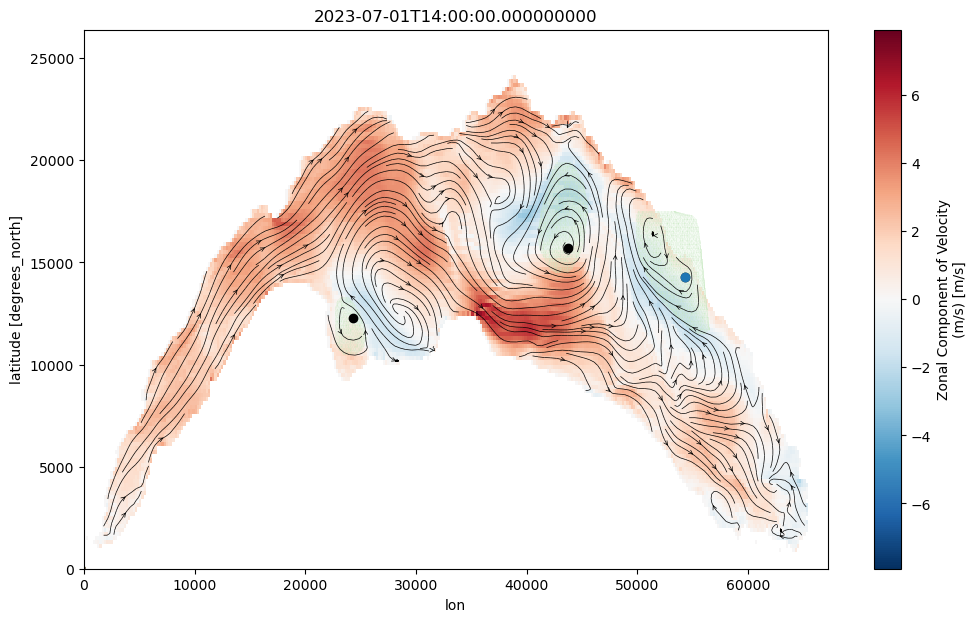

In [195]:
fig = plot_map_eddies(data_aligned.isel(time=t_index), 
                      test_eddies, 
                      str(data_aligned['time'].isel(time=t_index).values),
                      4)
plt.scatter(ec_lon,ec_lat)
for i in range(len(C)-1):
    plt.plot(C[i][0][:,0],C[i][0][:,1])

In [83]:
from matplotlib.path import Path
from scipy.spatial import ConvexHull

In [84]:
def inpolygon(point_i, point_j, x, y):
    p = np.array([x, y]).T
    hullp = ConvexHull(p)
    poly_path = Path(p[hullp.vertices])
    return poly_path.contains_point([point_i, point_j])

In [28]:
ec_lon

np.float64(58100.0)

In [85]:
# intialize the two variables
eddy_lim = []
largest_curve=[]
# rearrange all the contours in C to the structure array 'isolines'
# each element of isolines contains all the vertices of a given contour
# level of PSI
isolines = {}
isolines_max = []
i = 0
ii = 0
there_are_contours = True
while there_are_contours:
    for j in np.arange(len(C[ii])):
        isolines[i] = {}
        isolines[i]["x"] = []
        isolines[i]["y"] = []
        isolines[i]["x"] = list(C[ii][j][:, 0])
        isolines[i]["y"] = list(C[ii][j][:, 1])
        isolines_max.append(np.nanmax(isolines[i]["y"]))
        i += 1
    ii += 1
    try:
        test = C[ii]
        there_are_contours = True
    except:
        there_are_contours = False
# sort the contours accroding to their maximum latitude; this way the first
# closed contour across which velocity increases will also be the largest
# one (it's the one which extend further north).
sorted_iso = np.argsort(isolines_max)[::-1]
print(f"lenght iso: {len(sorted_iso)}")

lenght iso: 116


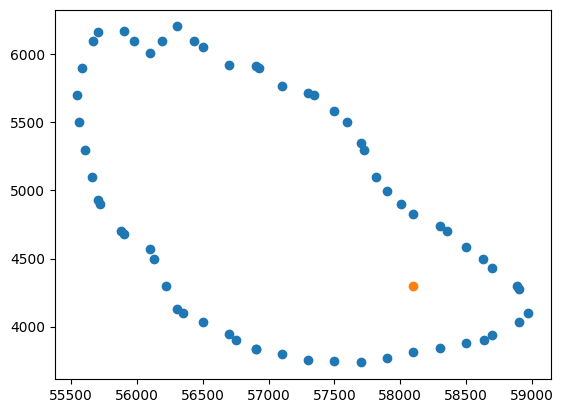

In [86]:
index_test=13
xdata_test = isolines[index_test]['x']
ydata_test = isolines[index_test]['y']
plt.scatter(xdata_test,ydata_test)
plt.scatter(ec_lon,ec_lat)

In [87]:
xdata_test

[np.float64(56900.0),
 np.float64(56749.24430499954),
 np.float64(56700.0),
 np.float64(56500.0),
 np.float64(56345.892637043304),
 np.float64(56300.0),
 np.float64(56218.101482625236),
 np.float64(56126.26286543481),
 np.float64(56100.0),
 np.float64(55900.0),
 np.float64(55876.39890799669),
 np.float64(55718.04621555848),
 np.float64(55700.0),
 np.float64(55655.90417685115),
 np.float64(55604.414856733),
 np.float64(55558.50291605927),
 np.float64(55546.400332745005),
 np.float64(55580.24003168923),
 np.float64(55666.208957774885),
 np.float64(55700.0),
 np.float64(55900.0),
 np.float64(55976.48406444187),
 np.float64(56100.0),
 np.float64(56185.502912192795),
 np.float64(56300.0),
 np.float64(56435.62288621864),
 np.float64(56500.0),
 np.float64(56700.0),
 np.float64(56900.0),
 np.float64(56923.02985238848),
 np.float64(57100.0),
 np.float64(57300.0),
 np.float64(57340.9026825204),
 np.float64(57500.0),
 np.float64(57592.44729851784),
 np.float64(57700.0),
 np.float64(57721.77217027

In [88]:
xdata_test[0] == xdata_test[-1]

np.True_

In [89]:
ydata_test[0] == ydata_test[-1]

np.True_

In [90]:
inpolygon(ec_lon, ec_lat, xdata_test, ydata_test)

True

In [91]:
from scipy import interpolate

In [92]:
# restart the counter and initialize the two flags
i = 0
closed_indx = 0 # set to 1 when eddy shape is found
largest_indx = 0 # set to 1 when largest closed contour is found
# inspect all isolines until the eddy shape is determined
# (closed_indx=1 stops the loop)
while ((closed_indx == 0) & (i < len(isolines))):
    ii = sorted_iso[i]
    xdata = isolines[ii]["x"] # vertex lon's
    ydata = isolines[ii]["y"] # vertex lat's
    # conditions to have the largest closed contour around the center
    # (isolines already sorted by maximum latitude)
    # 1) closed contours
    # 2) detected eddy center inside the polygon
    if ((len(xdata) < 3) | (len(ydata) < 3)):
        #print('xx Contour is not closed.')
        i += 1
        continue
    try:
        inpo = inpolygon(ec_lon, ec_lat, xdata, ydata)
    except Exception as e:
        print(ii)
        print(f'Error: {e}')
        inpo = False
    if ii == 13:
        print(xdata)
        print(ydata)
        print(((xdata[0] == xdata[-1]) & (ydata[0] == ydata[-1])) & inpo)
        
    if (((xdata[0] == xdata[-1]) & (ydata[0] == ydata[-1])) & inpo):
        print('Contour is closed.')
        # find the contour extremes
        Nj = np.max(ydata)
        Ni = np.max(xdata[int(np.where(ydata==Nj)[0][0])])
        Sj = np.min(ydata)
        Si = np.min(xdata[int(np.where(ydata==Sj)[0][0])])
        Ei = np.max(xdata)
        Ej = np.min(ydata[int(np.where(xdata==Ei)[0][0])])
        Wi = np.min(xdata)
        Wj = np.max(ydata[int(np.where(xdata==Wi)[0][0])])
        # check if velocity across the contour increases
        direct = ['N', 'S', 'E', 'W']
        pts_I = [Ni, Si, Ei, Wi]
        pts_J = [Nj, Sj, Ej, Wj]
        # inspect one extreme at the time (faster)
        iii = 0 # counter
        smaller_vel = 0  # flag to stop the loop (1 if velocity decreases
                         # across the fourth extremes)
        smaller_vel1 = 0 # flag to stop the loop (1 if velocity decreases
                         # across the third extremes)
        smaller_vel2 = 0 # flag to stop the loop (1 if velocity decreases
                         # across the second extremes)
        smaller_vel3 = 0 # flag to stop the loop (1 if velocity decreases
                         # across the first extremes)
        while ((iii < len(direct)) & (smaller_vel == 0)):
            # interpolate velocity across the extreme
            in_out_vel = interpolate_limits(pts_I[iii], pts_J[iii],
                                            lon, lat, dkm, vel, direct[iii])
            # change the flag value if velocity decreases
            if (in_out_vel[0] > in_out_vel[1]):
                if (smaller_vel3 == 0):
                    smaller_vel3 = 1
                elif (smaller_vel2 == 0):
                    smaller_vel2 = 1
                elif (smaller_vel1 == 0):
                    smaller_vel1 = 1
                elif (smaller_vel == 0):
                    smaller_vel = 1
            iii += 1 # increase the counter
        # only if velocity increases across all four extremes the closed
        # contour is saved as eddy shape
        if (smaller_vel == 0):
            eddy_lim = [xdata, ydata]
            closed_indx = 1
        # largest closed conotur is saved as well
        if (largest_indx == 0):
            largest_curve = [xdata, ydata]
            largest_indx = 1
    i += 1 # increase the counter
# in case velocity doesn't increase across the closed contour, eddy shape
# is defined simply as the largest closed contour
if ((eddy_lim==[]) & (largest_curve!=[])):
    print('Largest closed contour selected')
    eddy_lim = largest_curve
if eddy_lim==[]:
    print('None')
else:
    mask = inpolygon2D(lon.flatten(), lat.flatten(), eddy_lim[0], eddy_lim[1])
    eddy_mask = mask.reshape(np.shape(lon))
    eddy_j = np.where(eddy_mask)[0]
    eddy_i = np.where(eddy_mask)[1]

Contour is closed.


NameError: name 'interpolate_limits' is not defined

In [47]:
i = 70
ii = sorted_iso[i]
xdata = isolines[ii]["x"] # vertex lon's
ydata = isolines[ii]["y"] # vertex lat's
inpolygon(ec_lon, ec_lat, xdata, ydata)

True

In [48]:
(xdata[0] == xdata[-1]) & (ydata[0] == ydata[-1])

np.True_

In [65]:
d_j-n

NameError: name 'd_j' is not defined